In [2]:
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel, Matern

/Users/hritter/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
sklearn.__version__ 

'0.18.1'

# DATA IMPORTING AND CLEANING

# Creating Data Tables from Files

In [4]:
organics = pd.read_csv('organics.csv', encoding = "ISO-8859-1")

In [5]:
organics.head()

,"Table 5. Concentrations of selected anions, ammonium, and nitrous oxide in groundwater samples collected from wells and multilevel samplers, Ashumet Valley treated-wastewater plume, Cape Cod, Massachusetts, 2007.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,"[Source of data: Richard L. Smith, U.S. Geolog...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Well or multilevel-sampler port name,Altitude of midpoint of screen (ft),Sampling date,"Nitrate,\ndissolved\n(µM)","Nitrite,\ndissolved\n(µM)","Ammonium,\ndissolved\n(µM)","Chloride,\ndissolved\n(µM)","Sulfate,\ndissolved\n(µM)",Nitrous oxide (µM),NaN,NaN,NaN,NaN
2,FSW 168-M15-01PT,20.76,07/24/07,<2,<0.5,<2,239,53,0.009,NaN,NaN,NaN,NaN
3,FSW 168-M15-02GNT,10.76,07/24/07,172,<0.5,<2,616,40,0.079,NaN,NaN,NaN,NaN
4,FSW 168-M15-03RT,0.76,07/24/07,26,<0.5,<2,790,115,0.022,NaN,NaN,NaN,NaN


In [6]:
new_header = organics.iloc[1] #grab the first row for the header
organics = organics[2:] #take the data less the header row
organics.rename(columns = new_header, inplace=True)

In [7]:
organics.head()

,Well or multilevel-sampler port name,Altitude of midpoint of screen (ft),Sampling date,"Nitrate, dissolved (µM)","Nitrite, dissolved (µM)","Ammonium, dissolved (µM)","Chloride, dissolved (µM)","Sulfate, dissolved (µM)",Nitrous oxide (µM),nan,nan,nan,nan
2,FSW 168-M15-01PT,20.76,07/24/07,<2,<0.5,<2,239,53,0.009,NaN,NaN,NaN,NaN
3,FSW 168-M15-02GNT,10.76,07/24/07,172,<0.5,<2,616,40,0.079,NaN,NaN,NaN,NaN
4,FSW 168-M15-03RT,0.76,07/24/07,26,<0.5,<2,790,115,0.022,NaN,NaN,NaN,NaN
5,FSW 168-M15-05BKT,-9.24,07/24/07,60,<0.5,<2,336,82,0.006,NaN,NaN,NaN,NaN
6,FSW 168-M15-05BKT-D,-9.24,07/24/07,60,<0.5,<2,333,83,--,NaN,NaN,NaN,NaN


In [8]:
organics = organics.iloc[:, :9]

In [9]:
organics.dropna(axis=0, how='all', inplace=True)

In [10]:
organics.head()

,Well or multilevel-sampler port name,Altitude of midpoint of screen (ft),Sampling date,"Nitrate, dissolved (µM)","Nitrite, dissolved (µM)","Ammonium, dissolved (µM)","Chloride, dissolved (µM)","Sulfate, dissolved (µM)",Nitrous oxide (µM)
2,FSW 168-M15-01PT,20.76,07/24/07,<2,<0.5,<2,239,53,0.009
3,FSW 168-M15-02GNT,10.76,07/24/07,172,<0.5,<2,616,40,0.079
4,FSW 168-M15-03RT,0.76,07/24/07,26,<0.5,<2,790,115,0.022
5,FSW 168-M15-05BKT,-9.24,07/24/07,60,<0.5,<2,336,82,0.006
6,FSW 168-M15-05BKT-D,-9.24,07/24/07,60,<0.5,<2,333,83,--


In [11]:
new_header_2 = ['well', 'screen_alt_mid_ft', 'date', 'nitrate_um', 'nitrite_um', 'nh3_um', 'chloride_um', 'sulfate_um', 'n2o_um']
organics.columns=new_header_2 #renaming rows

In [12]:
organics['n2o_um2'] = organics['n2o_um']
organics.loc[organics['n2o_um'] == '<0.002', 'n2o_um2'] = 0.001

In [13]:
organics['n2o_um'] = organics['n2o_um2']

In [14]:
del organics['n2o_um2'] #end renaming rows

In [15]:
organics.head()

,well,screen_alt_mid_ft,date,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um
2,FSW 168-M15-01PT,20.76,07/24/07,<2,<0.5,<2,239,53,0.009
3,FSW 168-M15-02GNT,10.76,07/24/07,172,<0.5,<2,616,40,0.079
4,FSW 168-M15-03RT,0.76,07/24/07,26,<0.5,<2,790,115,0.022
5,FSW 168-M15-05BKT,-9.24,07/24/07,60,<0.5,<2,336,82,0.006
6,FSW 168-M15-05BKT-D,-9.24,07/24/07,60,<0.5,<2,333,83,--


# Merging Coordinates

In [16]:
coords_wells = pd.read_csv('coords_levels_wells.csv', encoding = "ISO-8859-1")

In [17]:
new_header = coords_wells.iloc[1] #grab the first row for the header
coords_wells = coords_wells[2:] #take the data less the header row
coords_wells.rename(columns = new_header, inplace=True)

In [18]:
coords_wells = coords_wells.iloc[:, :10]

In [19]:
coords_wells.dropna(axis=0, how='all', inplace=True)

In [20]:
coords_wells.head()

,Well name,Latitude,Longitude,Altitude of land surface (ft),Altitude of top of screen (ft),Altitude of bottom of screen (ft),Well diameter (in.),Well casing and screen material,Date of water-level measure-ment,Altitude of water level (ft)
2,FSW 230-0042,413818.38,703240.46,87.06,46.66,44.66,2.00,PVC,08/01/07,49.26
3,FSW 230-0048,413818.38,703240.46,86.20,47.80,37.80,2.00,PVC,08/01/07,49.26
4,FSW 230-0049,413818.38,703240.46,86.14,38.74,36.74,2.00,PVC,08/01/07,49.28
5,FSW 230-0058,413818.38,703240.46,85.93,29.93,27.93,2.00,PVC,08/01/07,49.26
6,FSW 230-0068,413818.38,703240.46,86.33,20.24,18.24,2.00,PVC,08/01/07,49.30


In [21]:
new_header_3 = ['well', 'lat', 'long', 'land_alt_ft', 'screen_top_ft', 'screen_bot_ft', 'del1', 'del2', 'del3', 'h2o_alt_ft']
coords_wells.columns=new_header_3

In [22]:
del coords_wells['del1']

In [23]:
del coords_wells['del2']
del coords_wells['del3']

In [24]:
coords_wells

,well,lat,long,land_alt_ft,screen_top_ft,screen_bot_ft,h2o_alt_ft
2,FSW 230-0042,413818.38,703240.46,87.06,46.66,44.66,49.26
3,FSW 230-0048,413818.38,703240.46,86.20,47.80,37.80,49.26
4,FSW 230-0049,413818.38,703240.46,86.14,38.74,36.74,49.28
5,FSW 230-0058,413818.38,703240.46,85.93,29.93,27.93,49.26
6,FSW 230-0068,413818.38,703240.46,86.33,20.24,18.24,49.30
7,FSW 230-0078,413818.38,703240.46,86.46,10.51,8.54,49.31
8,FSW 230-0088,413818.38,703240.46,86.35,0.32,-1.68,49.30
9,FSW 230-0108,413818.38,703240.46,86.13,-20.02,-22.02,49.29
10,FSW 230-0127,413818.38,703240.46,86.06,-39.33,-41.33,49.32
12,FSW 236-0070,413814.47,703249.89,98.05,30.15,28.15,49.94


In [25]:
coords_multi = pd.read_csv('coords_levels_multi.csv', encoding = "ISO-8859-1")

In [26]:
new_header = coords_multi.iloc[1] #grab the first row for the header
coords_multi = coords_multi[2:] #take the data less the header row
coords_multi.rename(columns = new_header, inplace=True)

In [27]:
coords_multi = coords_multi.iloc[:, :7]

In [28]:
new_header_3 = ['well', 'lat', 'long', 'land_alt_ft', 'screen_top_ft', 'screen_bot_ft', 'h2o_alt_ft']
coords_multi.columns=new_header_3

In [29]:
coords_multi.dropna(axis=0, how='all', inplace=True)

In [30]:
coords_multi.head()

,well,lat,long,land_alt_ft,screen_top_ft,screen_bot_ft,h2o_alt_ft
2,FSW 168-M15-01PT,413700.98,703258.18,44.71,20.81,20.71,37
3,FSW 168-M15-02GNT,413700.98,703258.18,44.71,10.81,10.71,37
4,FSW 168-M15-03RT,413700.98,703258.18,44.71,0.81,0.71,37
5,FSW 168-M15-05BKT,413700.98,703258.18,44.71,-9.19,-9.29,37
6,FSW 168-M15-06WT,413700.98,703258.18,44.71,-14.19,-14.29,37


In [31]:
coords_wells_multi = pd.concat([coords_wells, coords_multi]) #starting to merge tables

In [32]:
coords_wells_multi.head()

,well,lat,long,land_alt_ft,screen_top_ft,screen_bot_ft,h2o_alt_ft
2,FSW 230-0042,413818.38,703240.46,87.06,46.66,44.66,49.26
3,FSW 230-0048,413818.38,703240.46,86.20,47.80,37.80,49.26
4,FSW 230-0049,413818.38,703240.46,86.14,38.74,36.74,49.28
5,FSW 230-0058,413818.38,703240.46,85.93,29.93,27.93,49.26
6,FSW 230-0068,413818.38,703240.46,86.33,20.24,18.24,49.30


In [33]:
organics_coords = organics.merge(coords_wells_multi, how='left', on='well')

In [34]:
organics_coords.sample(5)

,well,screen_alt_mid_ft,date,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,long,land_alt_ft,screen_top_ft,screen_bot_ft,h2o_alt_ft
1053,SDW 318-M01-07O,34.91,05/17/07,18,<0.5,<2,343,89,--,413820.51,703243.57,68.04,34.96,34.86,50
216,FSW 343-M01-12R,-52.47,06/18/07,25,<0.5,<2,235,82,0.023,413814.59,703235.12,68.90,-52.42,-52.52,49
640,FSW 565-M01-12R-D,-43.41,05/30/07,45,<0.5,<2,487,93,--,NaN,NaN,NaN,NaN,NaN,NaN
512,FSW 472-M01-02GNT,4.66,06/21/07,15,<0.5,<2,263,59,--,413648.42,703302.63,40.29,4.71,4.61,34
780,FSW 585-0048 (30MW0585D),38.34,09/21/07,1457,<0.5,<2,581,55,--,413728.07,703232.00,81.34,43.34,33.34,41.26


# Merging Inorganics

In [35]:
inorganics = pd.read_csv('inorganics.csv', encoding = "ISO-8859-1")

In [36]:
new_header = inorganics.iloc[1] #grab the first row for the header
inorganics = inorganics[2:] #take the data less the header row
inorganics.rename(columns = new_header, inplace=True)

In [37]:
inorganics = inorganics.iloc[:, :23]

In [38]:
inorganics.dropna(axis=0, how='all', inplace=True)

In [39]:
inorganics.columns

Index(['Well or multilevel-sampler port name',
       'Altitude of midpoint of screen    (ft)', 'Sampling date',
       'Aluminum,\ndissolved\n(µM)', 'Arsenic,\ndissolved\n(µM)',
       'Boron,\ndissolved\n(µM)', 'Barium,\ndissolved\n(µM)',
       'Calcium,\ndissolved\n(µM)', 'Cadmium,\ndissolved\n(µM)',
       'Cobalt,\ndissolved\n(µM)', 'Copper,\ndissolved\n(µM)',
       'Iron,\ndissolved\n(µM)', 'Potassium,\ndissolved\n(µM)',
       'Lithium,\ndissolved\n(µM)', 'Magnesium,\ndissolved\n(µM)',
       'Manganese,\ndissolved\n(µM)', 'Sodium,\ndissolved\n(µM)',
       'Nickel,\ndissolved\n(µM)', 'Phosphorus,\ndissolved\n(µM)',
       'Sulfur, \ndissolved\n(µM)', 'Silica,\ndissolved\n(µM)',
       'Strontium,\ndissolved\n(µM)', 'Zinc,\ndissolved\n(µM)'],
      dtype='object')

In [40]:
inorganics_use = inorganics.iloc[:, [0,1,3,5,8,9,10,11,21,22]]

In [41]:
new_header_4 = ['well', 'alt_ft', 'Al_um', 'B_um', 'Cd_um', 'Co_um', 'Cu_um', 'Fe_um', 'Sr_um', 'Zn_um']
inorganics_use.columns=new_header_4

In [42]:
inorganics_use.head()

,well,alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
2,FSW 168-M15-01PT,20.76,3.80,0.6,<0.009,<0.02,<0.03,<0.09,0.20,0.20
3,FSW 168-M15-02GNT,10.76,<3.15,1.2,<0.009,<0.02,<0.03,<0.09,0.29,0.24
4,FSW 168-M15-03RT,0.76,<3.15,1.5,<0.009,<0.02,<0.03,<0.09,0.31,0.23
5,FSW 168-M15-05BKT,-9.24,<3.15,1.0,<0.009,<0.02,<0.03,<0.09,0.14,0.21
6,FSW 168-M15-05BKT-D,-9.24,<3.15,1.0,<0.009,<0.02,0.19,<0.09,0.14,1.63


In [43]:
org_inorg_coord = organics_coords.merge(inorganics_use, how='left', on='well')

In [44]:
org_inorg_coord.sample(5)

,well,screen_alt_mid_ft,date,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,...,h2o_alt_ft,alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
308,FSW 379-M01-07O,-2.28,05/14/07,<2,<0.5,<2,1430,129,--,413813.45,...,48,-2.28,<3.15,3.8,<0.009,0.12,<0.03,152.7,0.28,0.88
423,FSW 429-0068,-34.87,08/28/07,142,<0.5,<2,421,103,0.369,413622.27,...,28.43,-34.87,<3.15,4.5,<0.009,<0.02,<0.03,<0.09,0.28,0.17
1059,SDW 318-M01-13BU,22.96,05/17/07,22,<0.5,<2,1028,57,--,413820.51,...,50,22.96,3.93,1.1,<0.009,0.10,0.09,<0.09,0.28,1.88
1024,SDW 107-0133 (03MW1016B),-44.59,10/12/07,40,<0.5,<2,835,85,--,413825.47,...,49.16,-44.59,<3.15,1.2,<0.009,<0.02,<0.03,4.1,0.65,0.66
1136,SDW 469-M01-05BKT,32.23,06/27/07,44,<0.5,<2,261,89,0.019,413818.31,...,49,32.23,4.04,1.2,<0.009,0.03,0.30,0.1,0.25,1.98


In [45]:
org_inorg_coord.info() #this tells me how many missing data points are in the matrix

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 0 to 1287
Data columns (total 24 columns):
well                 1288 non-null object
screen_alt_mid_ft    1288 non-null object
date                 1288 non-null object
nitrate_um           1287 non-null object
nitrite_um           1287 non-null object
nh3_um               1287 non-null object
chloride_um          1287 non-null object
sulfate_um           1287 non-null object
n2o_um               1288 non-null object
lat                  1175 non-null object
long                 1175 non-null object
land_alt_ft          1175 non-null object
screen_top_ft        1175 non-null object
screen_bot_ft        1175 non-null object
h2o_alt_ft           1175 non-null object
alt_ft               1286 non-null object
Al_um                1286 non-null object
B_um                 1286 non-null object
Cd_um                1286 non-null object
Co_um                1286 non-null object
Cu_um                1286 non-null object
Fe_um      

In [46]:
org_inorg_coord.replace(to_replace ="<2", value=1, inplace=True) # replacing nondetects with half the detection limit

In [47]:
org_inorg_coord.replace(to_replace ="<0.5", value=0.25, inplace=True)
org_inorg_coord.replace(to_replace ="<3.15", value=1.575, inplace=True)
org_inorg_coord.replace(to_replace ="<0.009", value=0.0045, inplace=True)
org_inorg_coord.replace(to_replace ="<0.02", value=0.01, inplace=True)
org_inorg_coord.replace(to_replace ="<0.03", value=0.015, inplace=True)
org_inorg_coord.replace(to_replace ="<0.09", value=0.045, inplace=True)

In [48]:
org_inorg_coord.head(5)

,well,screen_alt_mid_ft,date,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,...,h2o_alt_ft,alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
0,FSW 168-M15-01PT,20.76,07/24/07,1,0.25,1,239,53,0.009,413700.98,...,37,20.76,3.80,0.6,0.0045,0.01,0.015,0.045,0.20,0.20
1,FSW 168-M15-02GNT,10.76,07/24/07,172,0.25,1,616,40,0.079,413700.98,...,37,10.76,1.575,1.2,0.0045,0.01,0.015,0.045,0.29,0.24
2,FSW 168-M15-03RT,0.76,07/24/07,26,0.25,1,790,115,0.022,413700.98,...,37,0.76,1.575,1.5,0.0045,0.01,0.015,0.045,0.31,0.23
3,FSW 168-M15-05BKT,-9.24,07/24/07,60,0.25,1,336,82,0.006,413700.98,...,37,-9.24,1.575,1.0,0.0045,0.01,0.015,0.045,0.14,0.21
4,FSW 168-M15-05BKT-D,-9.24,07/24/07,60,0.25,1,333,83,--,NaN,...,NaN,-9.24,1.575,1.0,0.0045,0.01,0.19,0.045,0.14,1.63


In [49]:
del org_inorg_coord['alt_ft']

In [50]:
del org_inorg_coord['date']

In [51]:
org_inorg_coord.head()

,well,screen_alt_mid_ft,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,long,...,screen_bot_ft,h2o_alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
0,FSW 168-M15-01PT,20.76,1,0.25,1,239,53,0.009,413700.98,703258.18,...,20.71,37,3.80,0.6,0.0045,0.01,0.015,0.045,0.20,0.20
1,FSW 168-M15-02GNT,10.76,172,0.25,1,616,40,0.079,413700.98,703258.18,...,10.71,37,1.575,1.2,0.0045,0.01,0.015,0.045,0.29,0.24
2,FSW 168-M15-03RT,0.76,26,0.25,1,790,115,0.022,413700.98,703258.18,...,0.71,37,1.575,1.5,0.0045,0.01,0.015,0.045,0.31,0.23
3,FSW 168-M15-05BKT,-9.24,60,0.25,1,336,82,0.006,413700.98,703258.18,...,-9.29,37,1.575,1.0,0.0045,0.01,0.015,0.045,0.14,0.21
4,FSW 168-M15-05BKT-D,-9.24,60,0.25,1,333,83,--,NaN,NaN,...,NaN,NaN,1.575,1.0,0.0045,0.01,0.19,0.045,0.14,1.63


In [52]:
org_inorg_coord.replace(to_replace ="<0.55", value=0.275, inplace=True)
org_inorg_coord.replace(to_replace ="<0.006", value=0.003, inplace=True)
org_inorg_coord.replace(to_replace ="<0.038", value=0.019, inplace=True)

In [53]:
#Checking to make sure I got all the detection limits:

In [54]:
org_inorg_coord.select_dtypes([np.object]).apply(lambda x: x.str.contains('<').any())

well                 False
screen_alt_mid_ft    False
nitrate_um           False
nitrite_um           False
nh3_um               False
chloride_um          False
sulfate_um           False
n2o_um               False
lat                  False
long                 False
land_alt_ft          False
screen_top_ft        False
screen_bot_ft        False
h2o_alt_ft           False
Al_um                False
B_um                 False
Cd_um                False
Co_um                False
Cu_um                False
Fe_um                False
Sr_um                False
Zn_um                False
dtype: bool

In [55]:
organics.select_dtypes([np.object]).apply(lambda x: x.str.contains('<').any())

well                 False
screen_alt_mid_ft    False
date                 False
nitrate_um            True
nitrite_um            True
nh3_um                True
chloride_um           True
sulfate_um            True
n2o_um               False
dtype: bool

In [56]:
org_inorg_coord.isnull().sum()

well                   0
screen_alt_mid_ft      0
nitrate_um             1
nitrite_um             1
nh3_um                 1
chloride_um            1
sulfate_um             1
n2o_um                 0
lat                  113
long                 113
land_alt_ft          113
screen_top_ft        113
screen_bot_ft        113
h2o_alt_ft           113
Al_um                  2
B_um                   2
Cd_um                  2
Co_um                  2
Cu_um                  2
Fe_um                  2
Sr_um                  2
Zn_um                  2
dtype: int64

In [57]:
df = org_inorg_coord

In [58]:
df[df.isnull().any(axis=1)]

,well,screen_alt_mid_ft,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,long,...,screen_bot_ft,h2o_alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
4,FSW 168-M15-05BKT-D,-9.24,60,0.25,1,333,83,--,NaN,NaN,...,NaN,NaN,1.575,1.0,0.0045,0.01,0.19,0.045,0.14,1.63
14,FSW 168-M16-07O-D,-20.12,134,0.25,10,345,69,--,NaN,NaN,...,NaN,NaN,1.575,2.3,0.0045,0.01,0.015,0.045,0.25,0.19
24,FSW 168-M15-09Y-D,-29.24,167,0.25,479,591,75,--,NaN,NaN,...,NaN,NaN,1.575,3.8,0.0045,0.01,0.015,0.045,0.15,0.18
35,FSW 230-0058-D,28.93,22,0.25,1,839,36,--,NaN,NaN,...,NaN,NaN,1.575,0.9,0.0045,0.03,0.015,0.045,0.13,1.43
44,FSW 236-0106-D,-6.40,30,0.25,1,536,76,--,NaN,NaN,...,NaN,NaN,1.575,1.0,0.0045,0.01,0.015,2.2,0.17,0.28
55,FSW 239-M01-08GY-D,6.28,45,6.7,1,375,128,--,NaN,NaN,...,NaN,NaN,1.575,3.0,0.0045,0.01,0.015,0.045,0.17,0.22
70,FSW 254-0072-D,-14.35,13,0.25,67,441,71,--,NaN,NaN,...,NaN,NaN,1.575,7.7,0.0045,0.01,0.015,2.8,0.21,0.19
81,FSW 262-0069-D,-20.50,148,0.25,1,340,74,--,NaN,NaN,...,NaN,NaN,1.575,2.7,0.0045,0.01,0.015,0.045,0.21,0.019
85,FSW 262-M01-09Y-D,-32.50,139,0.25,408,436,73,--,NaN,NaN,...,NaN,NaN,1.575,7.9,0.0045,0.01,2.29,0.045,0.19,1.53
97,FSW 267-0136-D,-79.87,36,0.25,1,986,135,--,NaN,NaN,...,NaN,NaN,1.575,0.7,0.0045,0.01,0.015,0.045,0.56,0.19


It looks like these are the duplicate samples, and it's fine to drop them. 

In [59]:
df.dropna(axis=0, how='any', inplace=True)

In [60]:
df.head()

,well,screen_alt_mid_ft,nitrate_um,nitrite_um,nh3_um,chloride_um,sulfate_um,n2o_um,lat,long,...,screen_bot_ft,h2o_alt_ft,Al_um,B_um,Cd_um,Co_um,Cu_um,Fe_um,Sr_um,Zn_um
0,FSW 168-M15-01PT,20.76,1,0.25,1,239,53,0.009,413700.98,703258.18,...,20.71,37,3.80,0.6,0.0045,0.01,0.015,0.045,0.20,0.20
1,FSW 168-M15-02GNT,10.76,172,0.25,1,616,40,0.079,413700.98,703258.18,...,10.71,37,1.575,1.2,0.0045,0.01,0.015,0.045,0.29,0.24
2,FSW 168-M15-03RT,0.76,26,0.25,1,790,115,0.022,413700.98,703258.18,...,0.71,37,1.575,1.5,0.0045,0.01,0.015,0.045,0.31,0.23
3,FSW 168-M15-05BKT,-9.24,60,0.25,1,336,82,0.006,413700.98,703258.18,...,-9.29,37,1.575,1.0,0.0045,0.01,0.015,0.045,0.14,0.21
5,FSW 168-M16-01PT,-13.12,116,0.25,1,344,70,0.001,413701.00,703258.19,...,-13.17,37,1.575,1.1,0.0045,0.01,0.015,0.045,0.16,0.26


In [61]:
df.to_pickle('raw_data.pkl') #saving the file

# MODELING 

The report said that the plume is characterized by nitrate, chloride, and boron, so let's start with those.

### 3-D:

In [62]:
df1 = df.iloc[:, [1,8,9,2,5,15]]

In [63]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1173 entries, 0 to 1285
Data columns (total 6 columns):
screen_alt_mid_ft    1173 non-null object
lat                  1173 non-null object
long                 1173 non-null object
nitrate_um           1173 non-null object
chloride_um          1173 non-null object
B_um                 1173 non-null object
dtypes: object(6)
memory usage: 64.1+ KB


In [64]:
df = df1.convert_objects(convert_numeric=True)

/Users/hritter/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [65]:
df.info() #here I'm noticing that the lat/long are not in numeric form, and in fact were not decimal lat/long 
#in the original table but looked like they were, so I'm converting them.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1173 entries, 0 to 1285
Data columns (total 6 columns):
screen_alt_mid_ft    1173 non-null float64
lat                  1173 non-null float64
long                 1173 non-null float64
nitrate_um           1173 non-null int64
chloride_um          1173 non-null int64
B_um                 1171 non-null float64
dtypes: float64(4), int64(2)
memory usage: 64.1 KB


In [66]:
def DMS_lat_to_dec(df):
    """dataframe, obs column,rim column"""
    df['lat2'] = df['lat']*100
    df.lat2 = df.lat2.astype(int)
    df.lat2 = df.lat2.astype(str)
    df['latS'] = df.lat2.str[-4:]
    df['latM'] = df.lat2.str[-6:-4]
    df['latD'] = df.lat2.str[-8:-6]
    df.latS = df.latS.astype(float)
    df.latM = df.latM.astype(float)
    df.latD = df.latD.astype(float)
    df['latS'] = df['latS']/100
    df['lat_dec'] = df['latD']+(df['latM']/60)+(df['latS']/3600)
    del df['lat2']
    del df['latS']
    del df['latM']
    del df['latD']
    return df

In [67]:
def DMS_long_to_dec(df):
    """dataframe, obs column,rim column"""
    df['long2'] = df['long']*100
    df.long2 = df.long2.astype(int)
    df.long2 = df.long2.astype(str)
    df['longS'] = df.long2.str[-4:]
    df['longM'] = df.long2.str[-6:-4]
    df['longD'] = df.long2.str[-8:-6]
    df.longS = df.longS.astype(float)
    df.longM = df.longM.astype(float)
    df.longD = df.longD.astype(float)
    df['longS'] = df['longS']/100
    df['long_dec'] = df['longD']+(df['longM']/60)+(df['longS']/3600)
    del df['long2']
    del df['longS']
    del df['longM']
    del df['longD']
    return df

In [68]:
DMS_long_to_dec(df)
DMS_lat_to_dec(df)

,screen_alt_mid_ft,lat,long,nitrate_um,chloride_um,B_um,long_dec,lat_dec
0,20.76,413700.98,703258.18,1,239,0.600,70.549494,41.616939
1,10.76,413700.98,703258.18,172,616,1.200,70.549494,41.616939
2,0.76,413700.98,703258.18,26,790,1.500,70.549494,41.616939
3,-9.24,413700.98,703258.18,60,336,1.000,70.549494,41.616939
5,-13.12,413701.00,703258.19,116,344,1.100,70.549497,41.616944
6,-14.12,413701.00,703258.19,125,349,1.100,70.549497,41.616944
7,-14.24,413700.98,703258.18,125,342,1.200,70.549494,41.616939
8,-15.12,413701.00,703258.19,132,365,1.200,70.549497,41.616944
9,-16.12,413701.00,703258.19,127,349,1.100,70.549497,41.616944
10,-18.12,413701.00,703258.19,133,414,1.700,70.549497,41.616944


In [69]:
df.dtypes

screen_alt_mid_ft    float64
lat                  float64
long                 float64
nitrate_um             int64
chloride_um            int64
B_um                 float64
long_dec             float64
lat_dec              float64
dtype: object

### Now I'm actually assigning X and Y variables for the model

In [70]:
X,y = df.drop(['chloride_um', 'nitrate_um', 'B_um', 'lat', 'long'], axis=1),df['nitrate_um']

In [71]:
y.max()

1457

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

notes on this gp1: n_restarts from an example. normalize y because ys don't avg around 0. Default alpha/noise; can change later.

In [73]:
gp1 = GaussianProcessRegressor(n_restarts_optimizer=9, normalize_y = True, alpha = 1e-2)

In [74]:
gp1.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.01, copy_X_train=True, kernel=None,
             n_restarts_optimizer=9, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [75]:
y_pred, sigma = gp1.predict(X_test, return_std=True)

In [76]:
gp1.score(X_test,y_test)

-0.30339845749364147

In [77]:
gp1.score(X_train,y_train) #??? it's not even overfit now.

0.29227582208936997

### Matern (exponential) kernel

In [78]:
kernel = Matern(nu=0.5)

In [79]:
gpM = GaussianProcessRegressor(n_restarts_optimizer=9, normalize_y = True, kernel=kernel, alpha=1e1)

In [80]:
gpM.fit(X_train, y_train)

/Users/hritter/anaconda/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:1362: RuntimeWarning: invalid value encountered in true_divide
  / np.sqrt(D.sum(2))[:, :, np.newaxis]


GaussianProcessRegressor(alpha=10.0, copy_X_train=True,
             kernel=Matern(length_scale=1, nu=0.5), n_restarts_optimizer=9,
             normalize_y=True, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [81]:
y_predM, sigmaM = gpM.predict(X_test, return_std=True)

In [82]:
gpM.score(X_test,y_test)

0.0020715159678900141

In [83]:
gp1.score(X_train,y_train)

0.29227582208936997

### 1D:

Taking a slice of the data:

In [84]:
df

,screen_alt_mid_ft,lat,long,nitrate_um,chloride_um,B_um,long_dec,lat_dec
0,20.76,413700.98,703258.18,1,239,0.600,70.549494,41.616939
1,10.76,413700.98,703258.18,172,616,1.200,70.549494,41.616939
2,0.76,413700.98,703258.18,26,790,1.500,70.549494,41.616939
3,-9.24,413700.98,703258.18,60,336,1.000,70.549494,41.616939
5,-13.12,413701.00,703258.19,116,344,1.100,70.549497,41.616944
6,-14.12,413701.00,703258.19,125,349,1.100,70.549497,41.616944
7,-14.24,413700.98,703258.18,125,342,1.200,70.549494,41.616939
8,-15.12,413701.00,703258.19,132,365,1.200,70.549497,41.616944
9,-16.12,413701.00,703258.19,127,349,1.100,70.549497,41.616944
10,-18.12,413701.00,703258.19,133,414,1.700,70.549497,41.616944


In [85]:
df.mode()

,screen_alt_mid_ft,lat,long,nitrate_um,chloride_um,B_um,long_dec,lat_dec
0,-45.95,413805.43,703225.22,1.0,180,1.1,70.540339,41.634842
1,NaN,NaN,NaN,NaN,192,NaN,NaN,NaN


/Users/hritter/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


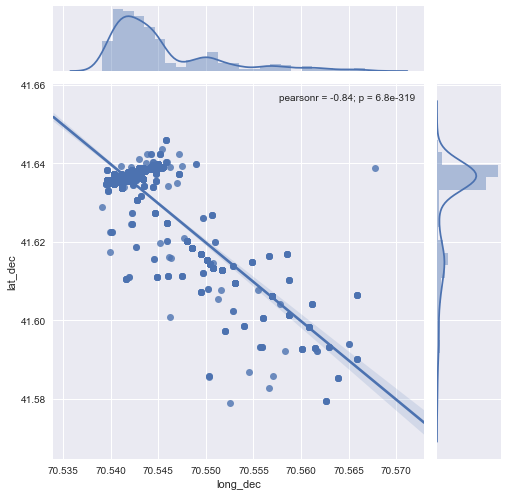

In [87]:
#plt.figure(figsize=(8, 6)) #can you colorize this by concentration? #at least turn off the trend line
sns.jointplot("long_dec", "lat_dec", kind="regplot", data=df, size=7)

In [88]:
df_slice = df[df['lat_dec'].between(41.638, 41.64, inclusive=True)]

In [89]:
df_slice

,screen_alt_mid_ft,lat,long,nitrate_um,chloride_um,B_um,long_dec,lat_dec
31,45.66,413818.38,703240.46,63,166,1.500,70.544572,41.638439
32,42.80,413818.38,703240.46,101,170,2.100,70.544572,41.638439
33,37.74,413818.38,703240.46,41,163,1.000,70.544572,41.638439
34,28.93,413818.38,703240.46,23,840,0.800,70.544572,41.638439
36,19.24,413818.38,703240.46,21,1130,0.900,70.544572,41.638439
37,9.52,413818.38,703240.46,41,439,1.200,70.544572,41.638439
38,-0.68,413818.38,703240.46,29,436,1.100,70.544572,41.638439
39,-21.02,413818.38,703240.46,30,493,1.100,70.544572,41.638439
40,-40.33,413818.38,703240.46,29,492,1.000,70.544572,41.638439
766,44.43,413817.19,703236.82,210,84,1.500,70.543561,41.638108


/Users/hritter/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


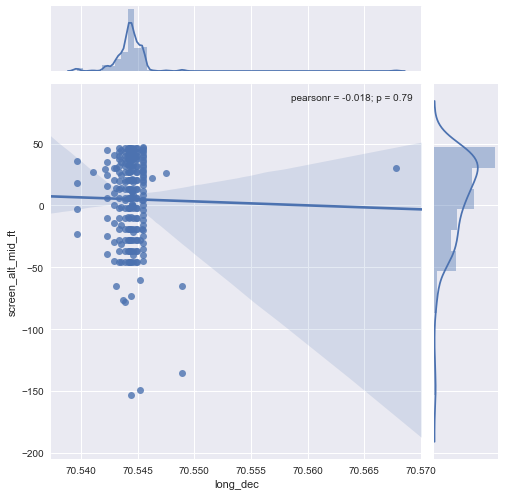

In [90]:
sns.jointplot("long_dec", "screen_alt_mid_ft", kind="regplot", data=df_slice, size=7)

In [91]:
df_slice2 = df_slice[df_slice['long_dec'].between(70.53, 70.550, inclusive=True)]

/Users/hritter/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


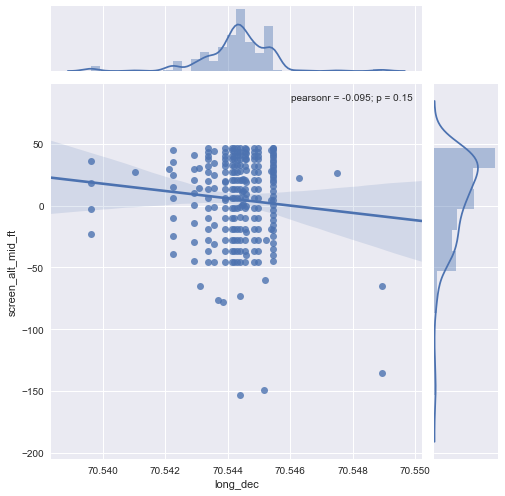

In [92]:
sns.jointplot("long_dec", "screen_alt_mid_ft", kind="regplot", data=df_slice2, size=7)

In [93]:
df['screen_alt_mid_ft'].max()

47.32

In [94]:
df_slice3 = df_slice2[df_slice2['screen_alt_mid_ft'].between(43, 47.32, inclusive=True)]

In [95]:
df_slice3.to_pickle('slice.pkl')

Running a model on the slice:

In [96]:
X_slice,y_slice = df_slice3.drop(['chloride_um', 'nitrate_um', 'B_um', 'screen_alt_mid_ft', 'long', 'lat', 'lat_dec'], axis=1),df_slice3['nitrate_um']

In [97]:
Xs_train, Xs_test, ys_train, ys_test = train_test_split(X_slice, y_slice, test_size=0.3)

In [98]:
gp_slice = GaussianProcessRegressor(n_restarts_optimizer=9, normalize_y = True, alpha = 0.5e-15)

In [99]:
gp_slice.fit(X_slice, y_slice)

GaussianProcessRegressor(alpha=5e-16, copy_X_train=True, kernel=None,
             n_restarts_optimizer=9, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [100]:
ys_pred, sigma = gp_slice.predict(X_slice, return_std=True)

/Users/hritter/anaconda/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [101]:
Xs_test = X_slice 
ys_test = y_slice

In [102]:
ys_pred_frame = pd.DataFrame(ys_pred, columns = ['ys_pred'])
sigma_frame = pd.DataFrame(sigma, columns = ['sigma'])
df_results = pd.concat([Xs_test.reset_index(), ys_test.reset_index(), ys_pred_frame, sigma_frame], axis=1)
del df_results['index']
df_results.sort_values('long_dec', ascending=True, inplace=True)
